In [32]:
import mrcfile
import file
from pathlib import Path
import glob
import numpy as np
import image_process
import matplotlib.pyplot as plt
import cv2
from datacube import DataCube
import plotly.offline as pyo
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np

In [33]:
# random 
random = False
def getRandomDc():
    mrc_search_path = '/mnt/experiment/TEM diffraction/'
    mrc_file_paths = [str(i) for i in Path(mrc_search_path).rglob("*.mrc")]
    random_mrc_paths = np.random.choice(mrc_file_paths,10)
    dc = DataCube(random_mrc_paths[1])
    
if random :
    mrc_search_path = '/mnt/experiment/TEM diffraction/'
    mrc_file_paths = [str(i) for i in Path(mrc_search_path).rglob("*.mrc")]
    random_mrc_paths = np.random.choice(mrc_file_paths,10)
    dc = DataCube(random_mrc_paths[1])
else :
    dc = DataCube('/mnt/experiment/TEM diffraction/210312 (copy)/sample49_TiiGe44_top_AD/Camera 230 mm Ceta 20210312 1333_50s_20f_area01.mrc')

In [34]:
dc.ready()
dc.calculate_center((130,140),10)
azavg, azvar = dc.calculate_azimuthal_average()

initial center is  (1219, 1086)


In [35]:
new_azavg = azavg * np.arange(0,len(azavg))
new_azavg = new_azavg*azavg.max()/new_azavg.max()
new_two = azavg * np.power(np.arange(0,len(azavg)),2)
new_two = new_two *azavg.max()/new_two.max()

In [36]:
rows, cols= 1,1
fig = make_subplots(rows,cols)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(azavg)),y=azavg, name="default"),
)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(azavg)),y=new_azavg, name="deafult*x_axis"),
)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(azavg)),y=new_two, name="deafult*x_axis^2"),
)
fig.update_layout(
    title_text="azimuthal average for different version",
    hovermode='x',
#     template="plotly_dark"
)
fig.show()

In [37]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.interpolate import make_interp_spline, BSpline
from scipy.ndimage.filters import gaussian_filter1d


x = np.arange(0,len(dc.azavg))
y = dc.azavg.copy()
x_smooth = np.linspace(x.min(), x.max(), int(len(dc.azavg)*0.3))
y_smooth = make_interp_spline(x, y)(x_smooth)
# plt.plot(x_smooth, y_smooth)
# plt.show()

ysmoothed = gaussian_filter1d(y, sigma=2)

rows, cols= 1,1
fig = make_subplots(rows,cols)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(azavg)),y=azavg, name="default"),
)
fig.add_trace(
    go.Scatter(x=x_smooth,y=y_smooth, name="BSpline"),
)
fig.add_trace(
    go.Scatter(x=x_smooth,y=ysmoothed, name="gaussian_1d"),
)
fig.update_layout(
    title_text="azimuthal average",
    hovermode='x',
#     template="plotly_dark"
)
fig.show()

In [38]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.signal import find_peaks

x = dc.azavg[0:int(len(dc.azavg)*0.3)]
peaks, _ = find_peaks(x, distance=20)
peaks2, _ = find_peaks(x, prominence=1)      # BEST!
peaks3, _ = find_peaks(x, width=20)
peaks4, _ = find_peaks(x, threshold=0.4)     # Required vertical distance to its direct neighbouring samples, pretty useless
peaks5, _ = find_peaks(-x, width=20)     # Required vertical distance to its direct neighbouring samples, pretty useless
peaks6, _ = find_peaks(-x, threshold=0.4)     # Required vertical distance to its direct neighbouring samples, pretty useless

rows, cols= 1,1
fig = make_subplots(rows,cols)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(azavg)),y=azavg, name="default"),
)
fig.add_trace(
    go.Scatter(x=peaks,y=dc.azavg[peaks], name="distance", mode='markers')  # marker={'size':10}
)
fig.add_trace(
    go.Scatter(x=peaks2,y=dc.azavg[peaks2], name="prominence", mode='markers')
)
fig.add_trace(
    go.Scatter(x=peaks3,y=dc.azavg[peaks3], name="width", mode='markers')
)
fig.add_trace(
    go.Scatter(x=peaks4,y=dc.azavg[peaks4], name="threshold", mode='markers')
)
fig.add_trace(
    go.Scatter(x=peaks5,y=dc.azavg[peaks5], name="low_width", mode='markers')
)
fig.add_trace(
    go.Scatter(x=peaks6,y=dc.azavg[peaks6], name="low_threshhold", mode='markers')
)
fig.update_layout(
    title_text="peak_finding",
    hovermode='x',
#     template="plotly_dark"
)

In [39]:
first_peak_idx = 1
for i in range(len(dc.azavg)):
    if dc.azavg[i] != 0:
        first_peak_idx = i
        break

In [40]:
range_slice = slice(first_peak_idx,first_peak_idx+int(len(dc.azavg)*0.3))
filtered_part = gaussian_filter1d(dc.azavg[first_peak_idx:first_peak_idx+int(len(dc.azavg)*0.3)], sigma=2)
azavg2 = dc.azavg.copy()
azavg2[range_slice] = filtered_part

rows, cols= 1,1
fig = make_subplots(rows,cols)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(azavg)),y=dc.azavg, name="default"),
)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(azavg)),y=azavg2, name="smooth_filtered")  # marker={'size':10}
)
fig.update_layout(
    title_text="smooth_filter",
    hovermode='x',
#     template="plotly_dark"
)

In [41]:
# smooth_filter + detect peak
x = azavg2[0:int(len(dc.azavg)*0.3)]
peaks, _ = find_peaks(x, distance=20)
low_peaks, _ = find_peaks(-x, distance=20)

rows, cols= 1,1
fig = make_subplots(rows,cols)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(azavg)),y=azavg2, name="smooth_filtered")  # marker={'size':10}
)
fig.add_trace(
    go.Scatter(x=peaks,y=azavg2[peaks], name="peaks", mode="markers"),
)
fig.add_trace(
    go.Scatter(x=low_peaks, y=azavg2[low_peaks], name="low_peaks", mode="markers")  # marker={'size':10}
)
fig.update_layout(
    title_text="smooth_filter + detect peak",
    hovermode='x',
#     template="plotly_dark"
)

In [42]:
# img = cv2.normalize(img,img,0,255,cv2.NORM_MINMAX)

mrc_search_path = '/mnt/experiment/TEM diffraction/'
mrc_file_paths = [str(i) for i in Path(mrc_search_path).rglob("*.mrc")]
random_mrc_paths = np.random.choice(mrc_file_paths,10)
dc2 = DataCube(random_mrc_paths[0])

dc2.ready()
dc2.calculate_center((130,140),10)
azavg, azvar = dc.calculate_azimuthal_average()

initial center is  (1239, 1084)


In [43]:
rows, cols= 1,1
fig = make_subplots(rows,cols)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(dc.azavg)),y=dc.azavg, name="default"),
)
fig.add_trace(
    go.Scatter(x=dc.azavg,y=dc2.azavg, name="other"),
)
fig.update_layout(
    title_text="compare",
    hovermode='x',
#     template="plotly_dark"
)

In [44]:
# second derivative

In [45]:
x = azavg2[0:int(len(dc.azavg)*0.3)]
peaks, _ = find_peaks(x, distance=20)
low_peaks, _ = find_peaks(-x, distance=20)

In [46]:
x = np.gradient(azavg2, 0.1)
peaks, _ = find_peaks(x, distance=20)
low_peaks, _ = find_peaks(-x, distance=20)

peaks = peaks[azavg2[peaks]!=0]
low_peaks = low_peaks[azavg2[low_peaks]!=0]

rows, cols= 1,1
fig = make_subplots(rows,cols)
fig.add_trace(
    go.Scatter(x=np.arange(0,len(azavg)),y=azavg2, name="smooth_filtered")  # marker={'size':10}
)
fig.add_trace(
    go.Scatter(x=peaks,y=azavg2[peaks], name="peaks", mode="markers"),
)
fig.add_trace(
    go.Scatter(x=low_peaks, y=azavg2[low_peaks], name="low_peaks", mode="markers")  # marker={'size':10}
)
fig.update_layout(
    title_text="find second order derivative",
    hovermode='x',
#     template="plotly_dark"
)
plt.plot(np.arange(0,len(azavg2)),azavg2)

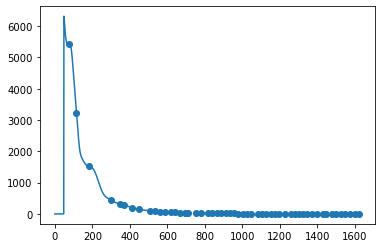

In [53]:
plt.plot(np.arange(0,len(azavg2))[0:600],azavg2[0:600])
plt.scatter(peaks,azavg2[peaks])

In [ ]:
랩북체크
해쉬태그
월요일 오후3시
내일 오후2시반~3시 derivative labookcheck with minhyo